## Разработка скоринговой модели предсказания дефолта клиентов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
DATASETS_LOC = '/kaggle/input/sf-dst-scoring'
RANDOM_SEED = 61

Мы располагаем следующей информацией из анкетных данных заемщиков:

* `client_id` - идентификатор клиента,
* `education` - уровень образования,
* `sex` - пол заемщика,
* `age` - возраст заемщика,
* `car` - флаг наличия автомобиля,
* `car_type` - флаг автомобиля иномарки,
* `decline_app_cnt` - количество отказанных прошлых заявок,
* `good_work` - флаг наличия "хорошей" работы,
* `bki_request_cnt` - количество запросов в БКИ,
* `home_address` - категоризатор домашнего адреса,
* `work_address` - категоризатор рабочего адреса,
* `income` - доход заемщика,
* `foreign_passport` - наличие загранпаспорта,
* `sna` - связь заемщика с клиентами банка,
* `first_time` - давность наличия информации о заемщике,
* `score_bki` - скоринговый балл по данным из БКИ,
* `region_rating` - рейтинг региона,
* `app_date` - дата подачи заявки,
* `default` - флаг дефолта по кредиту.

In [3]:
train = pd.read_csv(f'{DATASETS_LOC}/train.csv')
train.insert(0, '_test', False)

test = pd.read_csv(f'{DATASETS_LOC}/test.csv')
test.insert(0, '_test', True)

data = pd.concat([train, test], ignore_index=True)
# unique values count, first 10 unique values, null values count, type
data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

,nunique,<lambda>,null,dtype
_test,2,"[False, True]",0,bool
client_id,110148,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",0,int64
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",0,object
education,5,"[SCH, GRD, UGR, PGR, ACD, nan]",478,object
sex,2,"[M, F]",0,object
age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",0,int64
car,2,"[Y, N]",0,object
car_type,2,"[Y, N]",0,object
decline_app_cnt,24,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",0,int64
good_work,2,"[0, 1]",0,int64


Пропусков значений в данных нет за исключением признака уровня образования. Сохраним это сведение (введем новую категорию), потому что в первом приближении данные выглядят чистыми.

In [4]:
data.education.fillna('WOE', inplace=True)

Сгруппируем признаки для упрощения обработки.

In [5]:
target = 'default'
bin_features = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_features = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_features = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

Посмотрим на распределение количественных признаков.

In [6]:
def plot_grid(nplots, max_cols=2, figsize=(800/72, 600/72)):
    ncols = min(nplots, max_cols)
    nrows = (nplots // ncols) + min(1, (nplots % ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, constrained_layout=True)
    if nrows == 1:
        return axs
    return [axs[index // ncols, index % ncols] for index in range(nplots)]

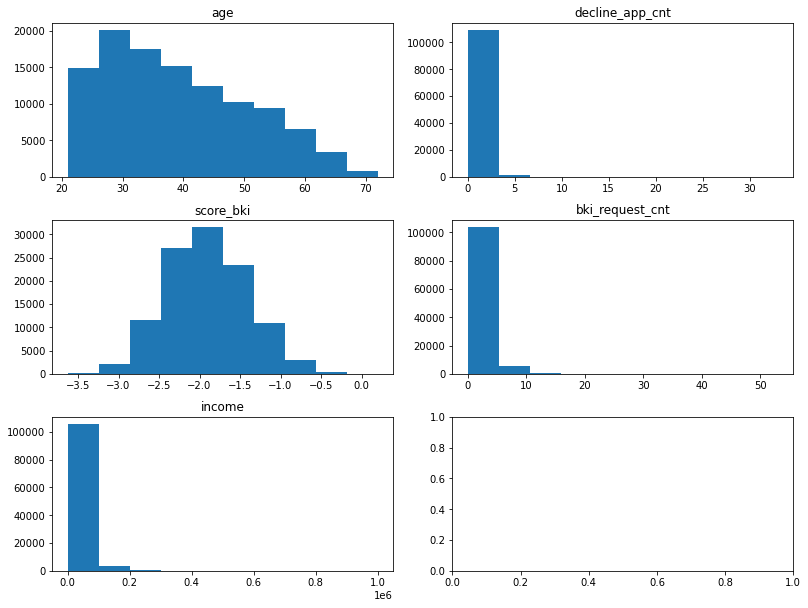

In [7]:
for column, ax in zip(num_features, plot_grid(len(num_features))):
    data[column].plot(kind='hist', ax=ax, title=column)
    ax.set_ylabel(None)

Распределение дохода имеет "длинный хвост" и большой масштаб относительно других признаков, поэтому применим функцию нормализации.

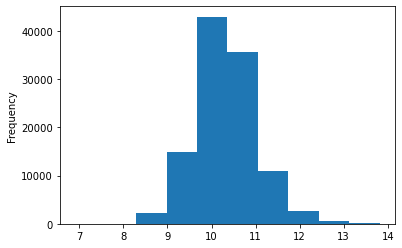

In [8]:
data.income = data.income.transform(np.log)
data.income.plot(kind='hist');

Посмотрим теперь на корреляцию признаков с целевой переменной.

In [9]:
def plot_correlation_matrix(corr, annot=False):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, annot=annot, fmt='.2f', mask=mask, cmap=cmap, vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .5})

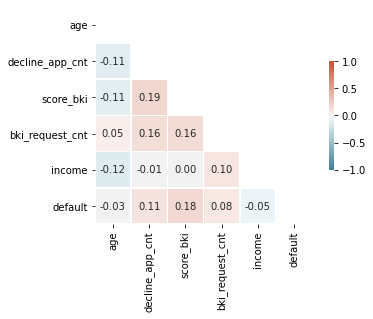

In [10]:
corr = data[~data._test][num_features + [target]].corr()
plot_correlation_matrix(corr, annot=True)

Наблюдается положительная корреляция целевой переменной с количеством отказов, что может объясняться самим процессом выдачи кредитов. Но в целом численные признаки скоррелированы слабо.

Проверим теперь значимость численных признаков.

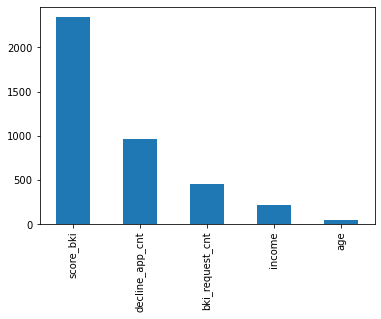

In [11]:
from sklearn.feature_selection import f_classif

F, _ = f_classif(data[~data._test][num_features], data[~data._test][target])
pd.Series(F, index=num_features).sort_values(ascending=False).plot(kind='bar');

Обратим внимание на то, что большее значение имеют признаки количества обращений и рейтинг бюро крединтных историй.

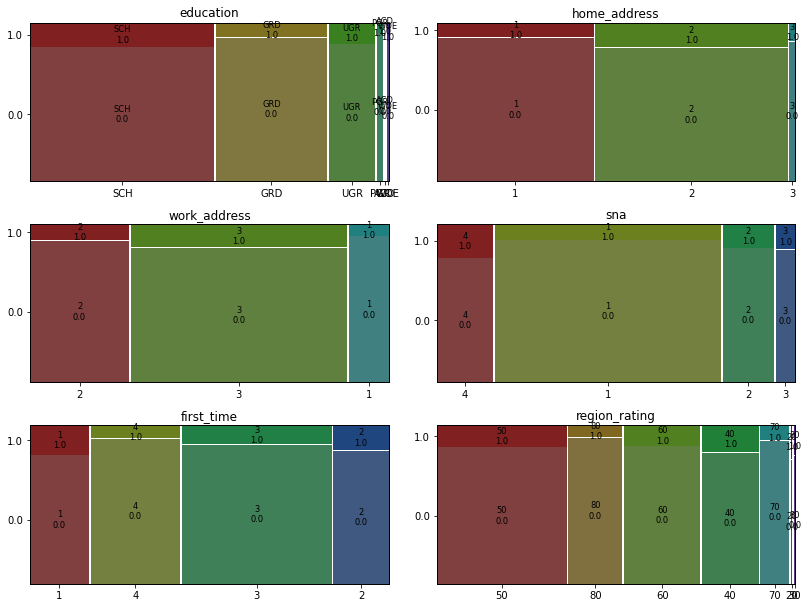

In [12]:
for feature, ax in zip(cat_features, plot_grid(len(cat_features))):
    mosaic(data[~data._test], [feature, target], ax=ax, title=feature);

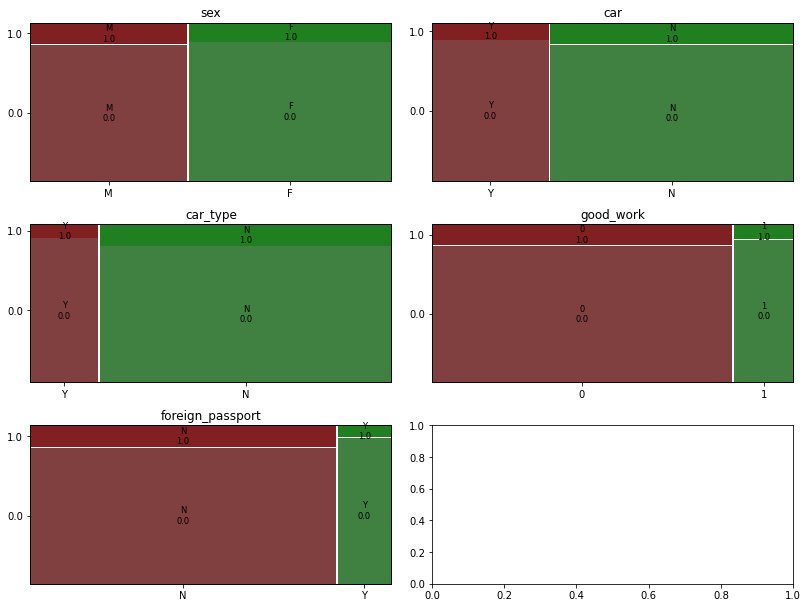

In [13]:
for feature, ax in zip(bin_features, plot_grid(len(bin_features))):
    mosaic(data[~data._test], [feature, target], ax=ax, title=feature);

В связи целевой переменной с категориальными признаками тоже не наблюдается явных закономерностей.

Оценим теперь значимость этих признаков, предварительно закодировав значения.

In [14]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


ordinal_enc = OrdinalEncoder(categories=[['WOE', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD'],])
data[['education',]] = ordinal_enc.fit_transform(data[['education',]])

label_encoder = LabelEncoder()
for column in bin_features:
    data[column] = label_encoder.fit_transform(data[column])

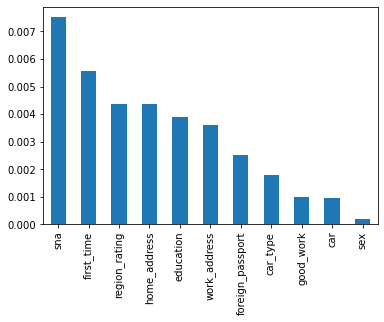

In [15]:
from sklearn.feature_selection import mutual_info_classif


mi = mutual_info_classif(data[~data._test][cat_features+bin_features], data[~data._test][target], discrete_features=True)
pd.Series(mi, index=cat_features+bin_features).sort_values(ascending=False).plot(kind='bar');

Связь с сотрудниками банка, а также, по-видимому, уровень жизни в окружении заемщика оказывают большее влияние на целевую переменную.

Подготовим данные к использованию в модели: закодируем категориальные признаки и стандартизируем численные.

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def prepare_space(df, num_features, bin_features, cat_features, target):
    X_num = StandardScaler().fit_transform(df[num_features].values)
    X_bin = df[bin_features].values
    X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_features].values)
    X = np.hstack([X_num, X_bin, X_cat])
    Y = df[target].values
    return X, Y

In [17]:
X, Y = prepare_space(data[~data._test], num_features, bin_features, cat_features, target)

In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=RANDOM_SEED)

Попробуем воспользоваться логистической регрессией, как относительно простым и быстрым алгоритмом машинного обучения.

In [19]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear').fit(X_train, y_train)

Оценим производительность модели по рабочей характеристике ROC.

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

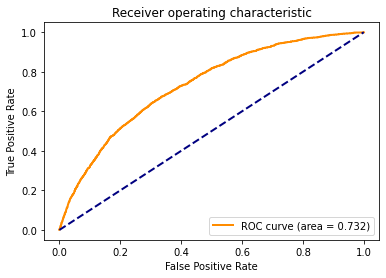

In [21]:
proba = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, proba)

Производительность нашей модели кажется неплохой, но вернемся в предметную область и взглянем на таблицу сопряженности оценки модели и реальных данных.

In [22]:
from sklearn.metrics import plot_confusion_matrix


def plot_cmatrix(estimator, X, y, title=None, **kwargs):
    disp = plot_confusion_matrix(model, X_test, y_test, **kwargs)
    disp.ax_.set_ylabel('Истинный класс')
    disp.ax_.set_xlabel('Предсказанный класс')
    if title:
        disp.ax_.set_title(title)

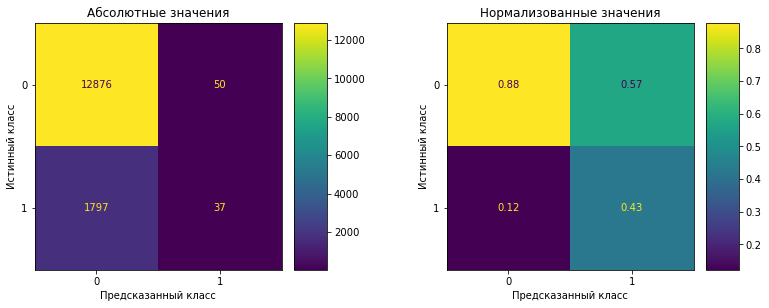

In [23]:
axs = plot_grid(2, figsize=(800/72, 300/72))
plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', normalize='pred', display_labels=['0', '1'], ax=axs[1]);

Заметна большая доля (12%) ложно-отрицательных значений, что может привести к убыткам из-за вышедших на дефолт кредитов, выданных потенциально ненадежным клиентам.

Но прежде чем идти на компромисс в выборе определяющего класс порога для векторов вероятностей, попробуем оптимизировать модель путем подбора параметров регрессии.

In [24]:
from sklearn.model_selection import GridSearchCV

estimator = LogisticRegression(random_state=RANDOM_SEED, max_iter=200)

param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'class_weight':['none', 'balanced'], 
        'multi_class': ['auto','ovr'],
    },
    {
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'class_weight':['none', 'balanced'], 
        'multi_class': ['auto','ovr'],
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'class_weight':['none', 'balanced'], 
        'multi_class': ['auto','ovr'],
    },
    {
        'penalty': ['none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'class_weight':['none', 'balanced'], 
        'multi_class': ['auto','ovr'],
    },
]

gs = GridSearchCV(estimator, param_grid, n_jobs=-1, scoring='f1', cv=5).fit(X_train, y_train)

Сразу испытаем найденные параметры на использованной ранее выборке.

In [25]:
params = gs.best_estimator_.get_params()
model = LogisticRegression(**params).fit(X_train, y_train)

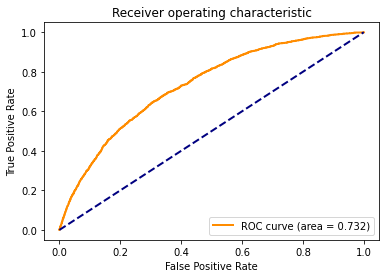

In [26]:
proba = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, proba)

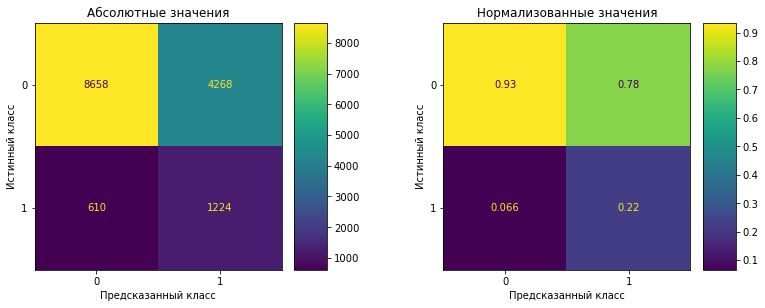

In [27]:
axs = plot_grid(2, figsize=(800/72, 300/72))
plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', normalize='pred', display_labels=['0', '1'], ax=axs[1]);

Что ж, производительность модели не улучшилась, и мы все же пришли к компромиссу: уменьшили долю риска по дефолтным кредитам за счет увеличения ложно-положительных исходов.

Опубликуем результаты.

In [28]:
S, _ = prepare_space(data[data._test], num_features, bin_features, cat_features, target)
predict_submission = model.predict_proba(S)[:,1]

In [29]:
sample_submission = data[data._test][['client_id', target]]
sample_submission[target] = predict_submission
sample_submission.to_csv('submission.csv', index=False)